# Spin-off project from Thesis: Curtailment 

In this project, we are going to explore the curtailment policy. That is, we allow PV systems to be installed beyond the limit that we have set in the thesis. We will see the relationship between the generation of PV systems where there is no constraint from a load profile and the generation of PV systems where the load profile is taken into account. The main assumption here is that the amount of PV curtailment can be done at any level at any time. That is, one can ramp the amount of PV generation down to any level simultaneously. 

## Basic case

In this workbook, we consider the basic case equivalent to the study of the fist limit. The plain load profile and maximum PV curves were used without the grid operation in the analysis.  

*Note:* The code is modified from ```02_08_Application_penetration_CA``` from the main folder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
from dateutil import tz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab

%matplotlib inline

In [3]:
####################################################Import data##############################################

#################### Import load data from CAISO #######################################

#specify data source 
#datasource = 'PJM'
#filename = 'pjm_e_load_data_2012.csv'
#datasource = 'CAISO/raw/caiso_load_data_2013'
datasource = 'CAISO/raw/caiso_load_data_2014'
#filename = 'caiso_north_load_data_2012.csv'

#timezone for local time adjustment
localtz = 'US/Pacific'

#specific to CAISO data
TacName = 'Caiso_Totals'#'TAC_NORTH'

mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
dataDir = mainDir + '/data/load/' + datasource +'/'
#outputDir = mainDir + '/output/'+ datasource +'/'

d01 = pd.read_csv(dataDir +'/'+ '01.csv')
d01 = d01[d01['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d02 = pd.read_csv(dataDir +'/'+ '02.csv')
d02 = d02[d02['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d03 = pd.read_csv(dataDir +'/'+ '03.csv')
d03 = d03[d03['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d04 = pd.read_csv(dataDir +'/'+ '04.csv')
d04 = d04[d04['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d05 = pd.read_csv(dataDir +'/'+ '05.csv')
d05 = d05[d05['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d06 = pd.read_csv(dataDir +'/'+ '06.csv')
d06 = d06[d06['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d07 = pd.read_csv(dataDir +'/'+ '07.csv')
d07 = d07[d07['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d08 = pd.read_csv(dataDir +'/'+ '08.csv')
d08 = d08[d08['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d09 = pd.read_csv(dataDir +'/'+ '09.csv')
d09 = d09[d09['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d10 = pd.read_csv(dataDir +'/'+ '10.csv')
d10 = d10[d10['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d11 = pd.read_csv(dataDir +'/'+ '11.csv')
d11 = d11[d11['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')
d12 = pd.read_csv(dataDir +'/'+ '12.csv')
d12 = d12[d12['TAC_ZONE_NAME']==TacName].sort_values(by='INTERVALSTARTTIME_GMT')

data = pd.concat([d01,d02,d03,d04,d05,d06,d07,d08,d09,d10,d11,d12])

data['tsLocal'] = data['INTERVALSTARTTIME_GMT'].map(lambda x: datetime.datetime.strptime(x[0:19],"%Y-%m-%dT%H:%M:%S")\
                                .replace(tzinfo=pytz.utc).astimezone(pytz.timezone(localtz)).strftime("%Y-%m-%d %H:%M:%S"))
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))


data = data[['tsLocal','MW']].reset_index().drop(['index'],1)
data.columns = ['tsLocal','load']

#delete double readings (can happen due to daylight savings)
data = data.groupby(['tsLocal']).mean().reset_index()
loaddata = data

In [4]:
#################### Define scope and join load data #######################################

#specify scope
StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,loaddata,on=['tsLocal'], how = 'left') 

#Interpolate load values to 15 mins
for j in range(1,2):
    for i in range(0,d.shape[0]/4-1):
        if (type(d.iloc[4*i,j])!=pd.tslib.NaTType) & (type(d.iloc[4*(i+1),j])!=pd.tslib.NaTType):
            #d.iloc[4*(i+1),1]=float('NaN')
            d.iloc[4*i+1,j] = 0.75*d.iloc[4*i,j]+0.25*d.iloc[4*(i+1),j]
            d.iloc[4*i+2,j] = 0.50*d.iloc[4*i,j]+0.50*d.iloc[4*(i+1),j]
            d.iloc[4*i+3,j] = 0.25*d.iloc[4*i,j]+0.75*d.iloc[4*(i+1),j]

In [5]:
#################### Import PV output data and join #######################################

[zipcode, PVcurve_shift] = ['92562',0.0862]
datasource = 'L'
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'
data = pd.read_csv(dataDir + '/training_data_fitted_adjusted.csv')

if type(data.tsLocal[0])==str:
    data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

#if pass 02_07p, then it is already adjusted and rewritten
#Adjust to guarantee maximum
#data['mpower'] = data['mpower'] + PVcurve_shift

#if pass 02_07p, then performance ratio is already calculated
#define performance ratio no need for shift anymore
#data['r'] = data.power/data.mpower

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(d,data,on=['tsLocal'], how = 'left') 

In [8]:
#################### Quick view of data #######################################

#Area under max power curve and expected power curve in MWh
#np.sum(d['mpower'])*15/60/1000,np.sum(d['mpower']*d['expectedr'])*15/60/1000

Ref = d.tsLocal.iloc[0].date()
x = d.tsLocal.map(lambda x: x.hour*60 + x.minute)
y = d.tsLocal.map(lambda x: (x.date()-Ref).days)
plt.clf()
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)

maxload = np.max(d['load'])

plt.scatter(x, y, c= d['load'],edgecolors='none',marker=',',s=20)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
cbar.ax.set_ylabel('load (-)')
ax1.set_xlim(0,1440)

ax1 = fig.add_subplot(122)

maxload = np.max(d['mpower'])

plt.scatter(x, y, c= d['mpower'],edgecolors='none',marker=',',s=20)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
cbar.ax.set_ylabel('load (-)')
ax1.set_xlim(0,1440)

## PV penetration

Here we run similar analysis to the first limit of PV penetration in the thesis. What we are interested more is the energy contribution from PV. Here we consider the ideal case (green) and the effective case (red). Note that "effective" is not same as actual since this calculation comes from maximum PV curves.

In [9]:
maxload = np.max(d['load'])
totaldemand = np.sum(d['load'])

def quick_penetration(i):
    
    d['solar'] = d['mpower']*maxload*i/100
    d['solar'][d['mpower'].isnull()] = 0
    d['netload'] = d['load'] - d['solar']
    d['check'] = 1-d['netload'].map(lambda x: x<0) #*maxload
    effectivedemand = np.sum(d['netload'][d['netload']>0])
    effectivecontribution = 1 - effectivedemand/totaldemand
    idealcontribution = np.sum(d['solar'])/totaldemand
    
    #Investigate all instances before it goes higher than 100%
    d['SolarRatio'] = d['solar']/d['load']
    if np.sum(d['SolarRatio']>1.0)>0:
        l = d['SolarRatio'][d[d['SolarRatio']>1.0].index-1]
        triggerratio = np.min(l)
    else:
        triggerratio = 1.0
    return effectivecontribution, idealcontribution, triggerratio;
    
    print effectivecontribution, idealcontribution, triggerratio
    

In [10]:
effective_c = [0]*100;
ideal_c = [0]*100;
trigger_r = [0]*100;
for i in range(100):
    effective_c[i], ideal_c[i], trigger_r[i] = quick_penetration(i);

C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


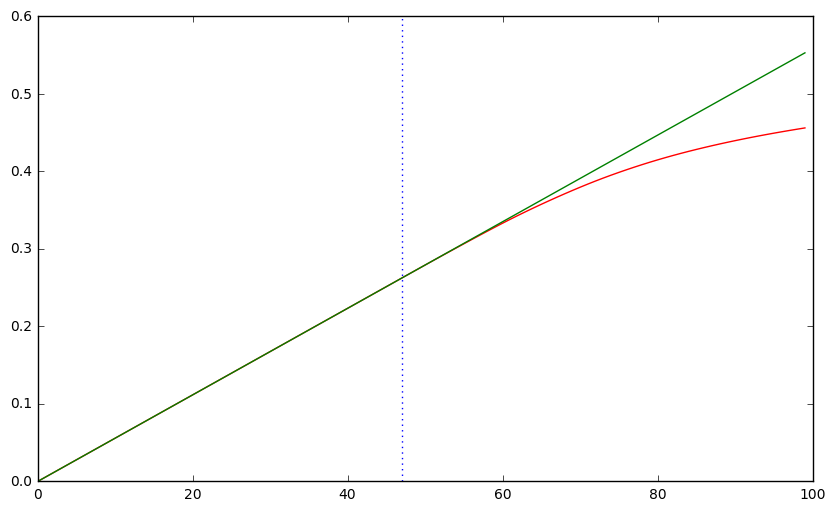

In [11]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(111)
plt.plot(range(100),effective_c,'red',label = 'effective')
plt.plot(range(100),ideal_c,'green',label = 'ideal')
plt.axvline(x=47,linestyle=':')


(0.8, 1.1)

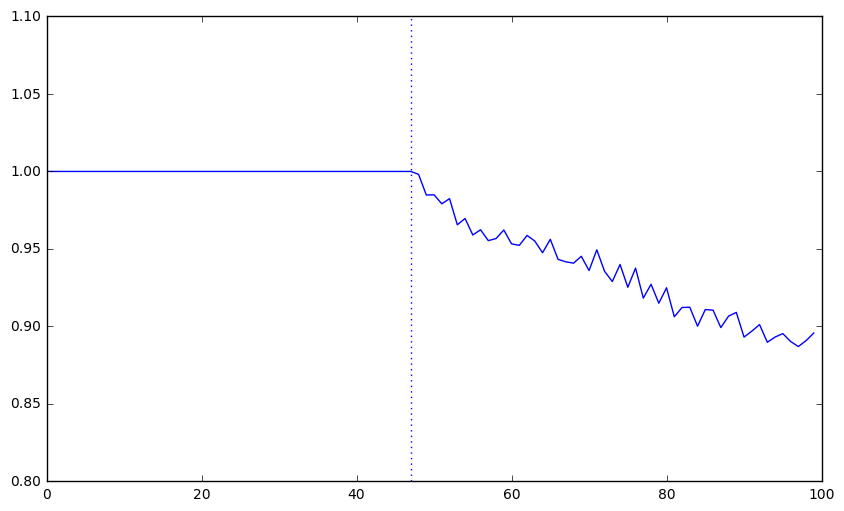

In [13]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(111)
plt.plot(range(100),trigger_r,'blue',label = 'trigger')
plt.axvline(x=47,linestyle=':')
plt.ylim(0.8,1.1)

## When to curtail PV generation

Here we are interested to see when the curtailment takes place. This is same as finding the location in the colormap where the net load is negative. Weekends and springs tend to be when we need to curtail PV generation.

C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


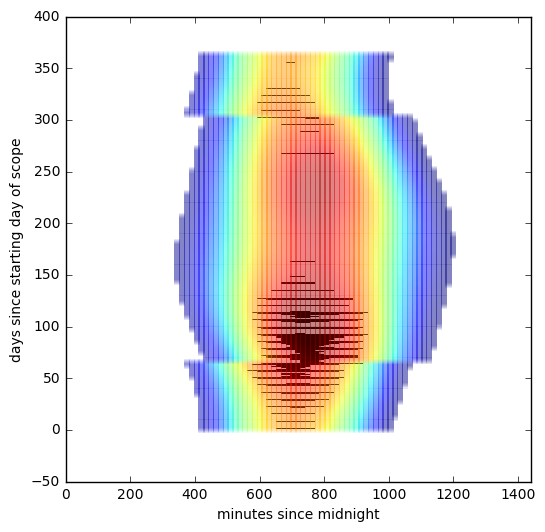

In [16]:
i = 60 #48, 50, 60, 70, 80, 90, 100
e_c, i_c, t_r = quick_penetration(i);
Ref = d.tsLocal.iloc[0].date()
x = d.tsLocal.map(lambda x: x.hour*60 + x.minute)
y = d.tsLocal.map(lambda x: (x.date()-Ref).days)

fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(111)

plt.scatter(x, y, c= d['check'],\
            cmap = 'gray',edgecolors='none',marker=',',s=20, vmin=0,vmax= 1)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
ax1.set_xlim(0,1440)
#cbar = plt.colorbar(ax=ax1)
#cbar.ax.set_ylabel('load (-)')
plt.scatter(x, y, c= d['mpower'],edgecolors='none',marker=',',s=20, alpha =.1)
